# Figure 4: Homogenous sequence contexts mediate differential tolerance to deletions versus substitutions

In [1]:
import paths
from Bio.Align import substitution_matrices
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import ks_2samp

### All UniProt sequences (canonical and isoforms) via Sequence column of https://www.uniprot.org/uniprotkb?query=Human&facets=model_organism%3A9606%2Creviewed%3Atrue

In [2]:
uniprot_sequences = pd.read_csv("../data/uniprot_sequences_all.tsv.gz", sep="\t")
# for faster querying
uniprot_sequences = {r[1].Entry: r[1].Sequence for r in uniprot_sequences.iterrows()}

In [3]:
# extract the neighboring residues from a position within a sequence
aa_window = lambda seq, pos: seq[max(0, pos-1):pos] + \
                             seq[pos] + \
                             seq[pos+1:min(pos+2, len(seq))]

In [4]:
all_aas = {'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'}

### Load in genome-wide and differentially tolerant data

In [5]:
del_sub = pd.read_csv(paths.DEL_SUB).assign(aPLLR=lambda x: np.abs(x.PLLR))[["site", "prot", "aPLLR", "avg_LLR"]].assign(pos=lambda x: x.site.str[1:].astype(int))
del_sub["log_aPLLR"] = -np.log10(del_sub.aPLLR)
# restrict to canonical transcripts
del_sub = del_sub[~del_sub.prot.str.contains("-")]

cutoff=25
del_tol, del_intol = np.percentile(del_sub.aPLLR, cutoff), np.percentile(del_sub.aPLLR, 100-cutoff)
sub_intol, sub_tol = np.percentile(del_sub.avg_LLR, cutoff), np.percentile(del_sub.avg_LLR, 100-cutoff)

del_intol_sub_tol = del_sub[(del_sub.aPLLR > del_intol) & (del_sub.avg_LLR > sub_tol)]
del_tol_sub_intol = del_sub[(del_sub.aPLLR < del_tol) & (del_sub.avg_LLR < sub_intol)]

/home/grant/anaconda3/envs/diff-tol/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Random protein sequence fragments from UniProt

In [6]:
all_ids = list(uniprot_sequences.keys())
random_seqs = []
for _ in range(del_tol_sub_intol.shape[0]):
    rand_prot = random.randint(0, len(all_ids)-1)
    rand_seq = uniprot_sequences[all_ids[rand_prot]]
    if len(rand_seq) >= 3:
        rand_pos = random.randint(1, len(rand_seq)-2)
        target_seq = rand_seq[rand_pos-1:rand_pos+2]
        # filter out non-canonical residues
        if len(set(target_seq) & all_aas) == len(set(target_seq)):
            random_seqs.append(target_seq)

In [7]:
del_intol_sub_tol["Sequence"] = del_intol_sub_tol.prot.map(uniprot_sequences)
del_tol_sub_intol["Sequence"] = del_tol_sub_intol.prot.map(uniprot_sequences)

del_intol_sub_tol_window = del_intol_sub_tol.apply(lambda x: aa_window(x.Sequence, x.pos-1), axis=1)
del_tol_sub_intol_window = del_tol_sub_intol.apply(lambda x: aa_window(x.Sequence, x.pos-1), axis=1)

/tmp/ipykernel_2508615/1627532164.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del_intol_sub_tol["Sequence"] = del_intol_sub_tol.prot.map(uniprot_sequences)
/tmp/ipykernel_2508615/1627532164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del_tol_sub_intol["Sequence"] = del_tol_sub_intol.prot.map(uniprot_sequences)


## Figure A

In [8]:
sequence_homogeneity_blosum = lambda mat, seq: mat[seq[0], seq[1]] + mat[seq[1], seq[2]]

In [9]:
bmat = substitution_matrices.load('BLOSUM62')

### Plot data

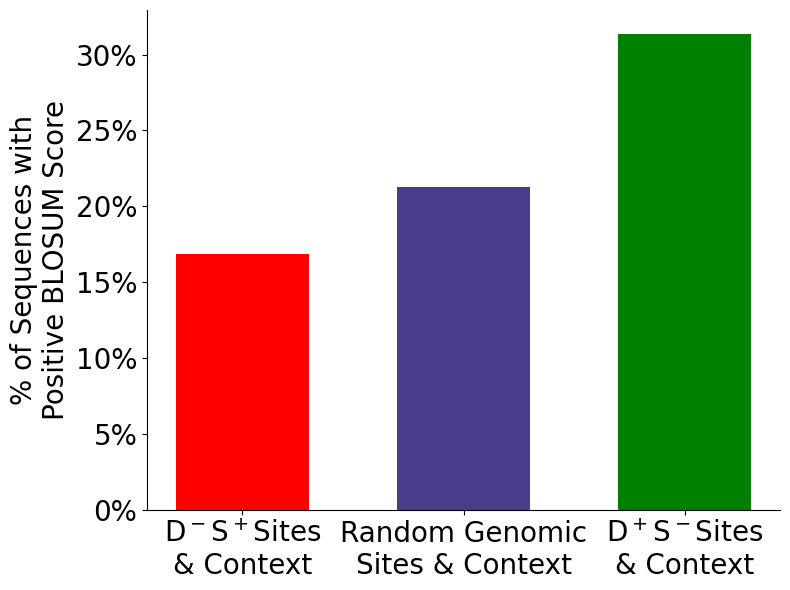

In [10]:
plt.figure(figsize=(8, 6))
rand_seq_scores = [sequence_homogeneity_blosum(bmat, x) for x in random_seqs]
del_intol_sub_tol_scores = [sequence_homogeneity_blosum(bmat, x) for x in
                          del_intol_sub_tol_window[del_intol_sub_tol_window.apply(len) == 3]]
del_tol_sub_intol_scores = [sequence_homogeneity_blosum(bmat, x) for x in
                            del_tol_sub_intol_window[del_tol_sub_intol_window.apply(len) == 3]]
plt.bar([1, 2, 3], [len(list(filter(lambda x: x > 0, score))) / len(score)
                    for score in [del_intol_sub_tol_scores, rand_seq_scores, del_tol_sub_intol_scores]],
             color=["red", "darkslateblue", "green"], width=0.6)
plt.xticks([1, 2, 3], [r'D$^-$S$^+$' + "Sites\n& Context", "Random Genomic\nSites & Context", r'D$^+$S$^-$' + "Sites\n& Context"],
           fontsize=20)
plt.yticks(np.arange(0, 0.35, step=0.05), [f"{int(x*100)}%" for x in np.arange(0, 0.35, step=0.05)],
           fontsize=20)
plt.ylabel("% of Sequences with\nPositive BLOSUM Score", fontsize=20)

plt.gca().spines[["top", "right"]].set_visible(False)
plt.tight_layout()
plt.show()

## Figure B

### Via https://academic.oup.com/bioinformatics/article/40/2/btae061/7600424

In [11]:
clusters = {
    "UNIPROT20": "A R N D C Q E G H I L K M F P S T W Y V",
    "HSDM17": "A D KE R N T S Q Y F LIV M C W H G P",
    "MMSEQS12": "AST LM IV KR EQ ND FY C G H P W",
}

amino_acid_cluster = {}

# create a simple mapping for each algorithm
for algorithm, clustering in clusters.items():
    res_dict = {}
    amino_acids = clustering.split()
    cluster_num = 0
    for amino_acid in amino_acids:
        for a in amino_acid:
            res_dict[a] = cluster_num
        cluster_num += 1
    amino_acid_cluster[algorithm] = res_dict

# count the unique clusters captured in a sequence, as determined by `algorithm` 
seq_cluster = lambda alg, seq: len({alg[c] for c in seq})
# count the number of residues that correspond to a specified cluster `clust`, as determined by `algorithm`
res_in_cluster = lambda alg, clust, seq: sum([1 if alg[c] == clust else 0 for c in seq])-1

### Number of clusters represented in a sequence per algorithm

In [12]:
num_cluster_algo = {a: [pd.Series([seq_cluster(amino_acid_cluster[a], s) for s in seqs]).mean() for seqs in 
                       [random_seqs, del_intol_sub_tol_window, del_tol_sub_intol_window]] for a in clusters.keys()}

In [13]:
target_cluster_algo = {a: [pd.Series([res_in_cluster(amino_acid_cluster[a], amino_acid_cluster[a][s[1]], s) for s in seqs]).mean() for seqs in 
                          [random_seqs, del_intol_sub_tol_window, del_tol_sub_intol_window]] for a in clusters.keys()}

### Plot data

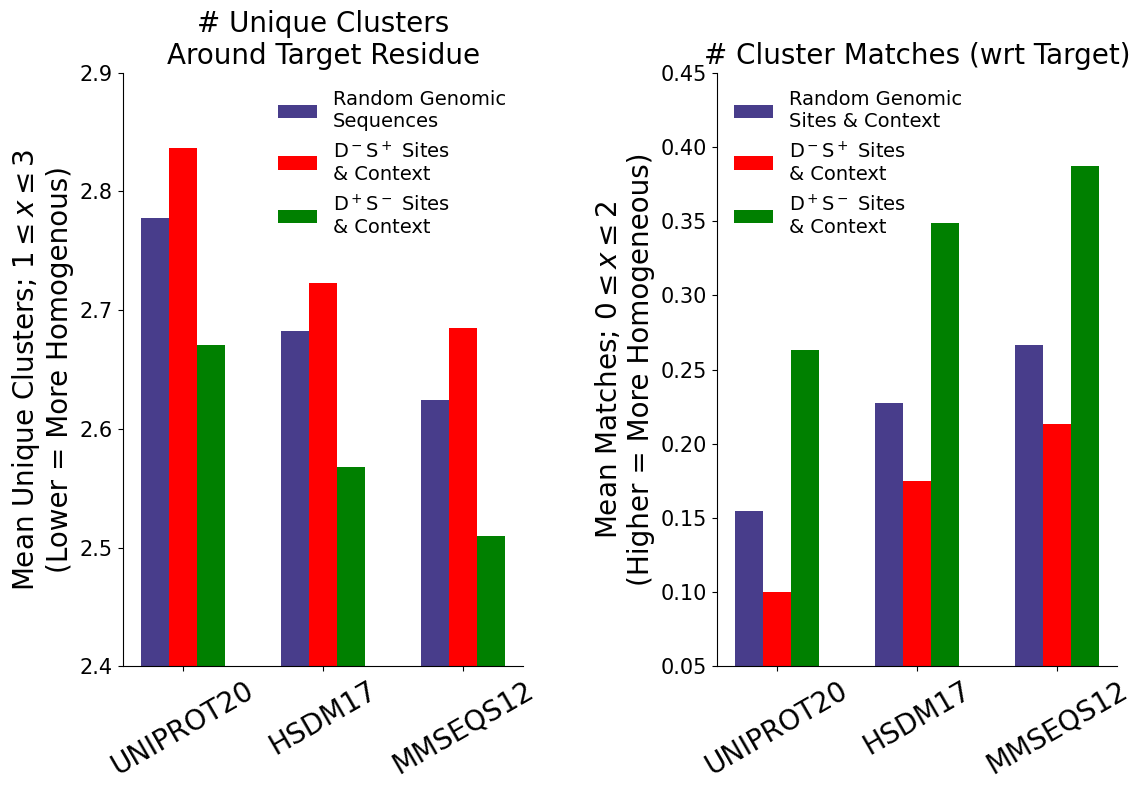

In [14]:
# Create a wider figure
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

# the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
values1 = [num_cluster_algo[a][0] for a in clusters.keys()]
values2 = [num_cluster_algo[a][1] for a in clusters.keys()]
values3 = [num_cluster_algo[a][2] for a in clusters.keys()]

r1 = np.arange(len(clusters.keys()))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width*2 for x in r1]

# Create the grouped bar plot
axs[0].bar(r1, values1, color='darkslateblue', width=bar_width, label='Random Genomic\nSequences')
axs[0].bar(r2, values2, color='r', width=bar_width, label=r'D$^-$S$^+$ Sites' + "\n& Context")
axs[0].bar(r3, values3, color='g', width=bar_width, label=r'D$^+$S$^-$ Sites' + "\n& Context")

# Add labels and title
# axs[0].set_xlabel('Amino Acid Clustering', size=15)
axs[0].set_ylabel('Mean Unique Clusters; ' + r'$1\leq x \leq 3$' + "\n(Lower = More Homogenous)", fontsize=20)
axs[0].set_xticks([r + bar_width for r in range(len(clusters.keys()))])
axs[0].set_xticklabels(clusters.keys(), fontsize=20, rotation=30)
axs[0].tick_params(axis='y', labelsize=15)
axs[0].set_title("# Unique Clusters\nAround Target Residue", size=20)
axs[0].set_ylim(2.4, 2.9)
axs[0].spines[["top", "right"]].set_visible(False)

values1 = [target_cluster_algo[a][0] for a in clusters.keys()]
values2 = [target_cluster_algo[a][1] for a in clusters.keys()]
values3 = [target_cluster_algo[a][2] for a in clusters.keys()]

# Set the positions of the bars on the x-axis
r1 = np.arange(len(clusters.keys()))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width*2 for x in r1]

# Create the grouped bar plot
axs[1].bar(r1, values1, color='darkslateblue', width=bar_width, label='Random Genomic\nSites & Context')
axs[1].bar(r2, values2, color='r', width=bar_width, label=r'D$^-$S$^+$ Sites' + "\n& Context")
axs[1].bar(r3, values3, color='g', width=bar_width, label=r'D$^+$S$^-$ Sites' + "\n& Context")

# Add labels and title
axs[1].set_ylabel("Mean Matches; " + r'$0\leq x \leq2$' + "\n(Higher = More Homogeneous)", fontsize=20)
axs[1].set_xticks([r + bar_width for r in range(len(clusters.keys()))])
axs[1].set_xticklabels(clusters.keys(), fontsize=20, rotation=30)
axs[1].tick_params(axis='y', labelsize=15)
axs[1].set_title("# Cluster Matches (wrt Target)", size=20)
axs[1].spines[['top', 'right']].set_visible(False)
axs[1].set_ylim(0.05, 0.45)

# Add legend
axs[0].legend(frameon=False, fontsize=14)
axs[1].legend(frameon=False, fontsize=14)
plt.subplots_adjust(wspace=5)
plt.tight_layout()
plt.show()

## Figure C

### Load in data

In [15]:
ins_sub_scan = pd.read_csv("../data/esm_ins_sub_pllr.csv.gz").assign(site=lambda x: x.insertion.str.split("_", expand=True)[0])

### Check if a mutation is posivie blosum wrt an amino acid

In [16]:
positive_blosum = {}
for aa1 in all_aas:
    positive_blosum[aa1] = []
    for aa2 in all_aas:
        if bmat[aa1,aa2] > 0:
            positive_blosum[aa1].append(aa2)

In [17]:
check_positive_blosum = lambda ref, mut: mut in positive_blosum[ref]

### Merge del-sub data with scans

In [18]:
del_intol_sub_tol_scan_muts = del_intol_sub_tol.merge(ins_sub_scan, on=["prot", "site"])[["site", "prot", "insertion", "ins_PLLR"]]
del_tol_sub_intol_scan_muts = del_tol_sub_intol.merge(ins_sub_scan, on=["prot", "site"])[["site", "prot", "insertion", "ins_PLLR"]]

### Plot data

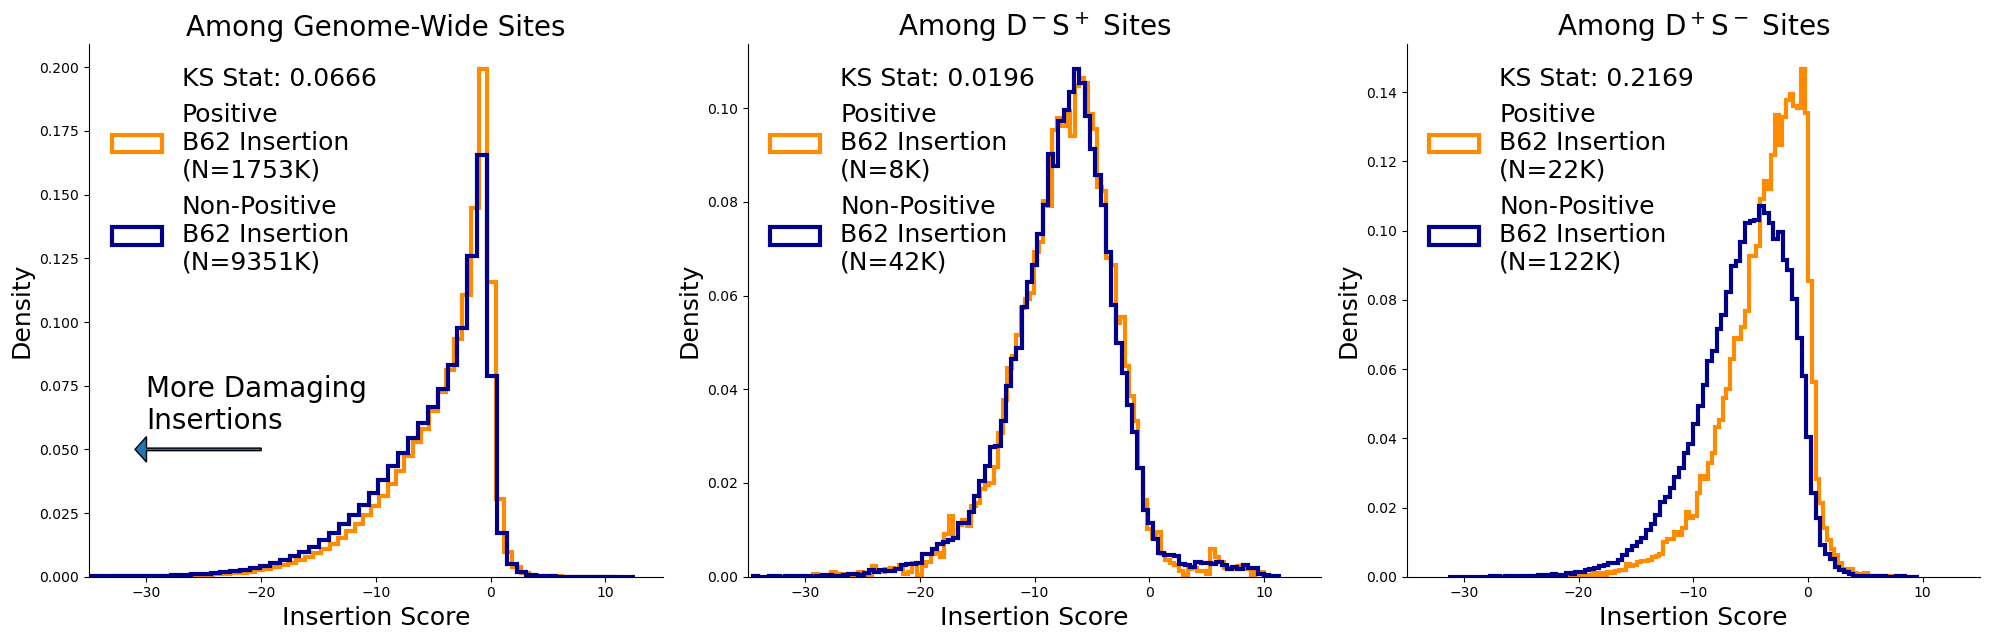

In [19]:
fig, axs=plt.subplots(1, 3, figsize=(20, 6.5))
for i, dataset, dataset_desc in zip([0, 1, 2], [ins_sub_scan, del_intol_sub_tol_scan_muts, del_tol_sub_intol_scan_muts],
                                    ["Among Genome-Wide", r'Among D$^-$S$^+$', r'Among D$^+$S$^-$']):
    
    dataset["positive_blosum"] = dataset.apply(lambda x: check_positive_blosum(x.insertion[0], x.insertion[-1]), axis=1)
    
    ks_stat = ks_2samp(dataset[~dataset.positive_blosum]["ins_PLLR"], dataset[dataset.positive_blosum]["ins_PLLR"]).statistic
    
    axs[i].plot([], [], label=f"KS Stat: {np.round(ks_stat, 4)}", color="white")
    _=axs[i].hist(dataset[dataset.positive_blosum]["ins_PLLR"], histtype="step", bins=100, density=True, color="darkorange", lw=3,
                  label=f"Positive\nB62 Insertion\n(N={int(np.round(dataset[dataset.positive_blosum].shape[0]/1000))}K)")
    _=axs[i].hist(dataset[~dataset.positive_blosum]["ins_PLLR"], histtype="step", bins=100, density=True, color="darkblue", lw=3,
                  label=f"Non-Positive\nB62 Insertion\n(N={int(np.round(dataset[~dataset.positive_blosum].shape[0]/1000))}K)")

    axs[i].set_xlabel(f"Insertion Score", size=18)
    axs[i].set_ylabel("Density", size=18)

    axs[i].legend(frameon=False, fontsize=18)
    axs[i].set_title(f"{dataset_desc} Sites", size=20)
    axs[i].set_xlim(-35, 15)
    axs[i].spines[["top", "right"]].set_visible(False)
    
    if i == 0:
        axs[i].arrow(-20, 0.05, -10, 0, head_length=1, head_width=0.01)
        axs[i].text(-30, 0.058, "More Damaging\nInsertions", size=20)

plt.tight_layout()
plt.show()